In [1]:
import os
import glob
import zipfile
import functools

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['axes.grid'] = False
mpl.rcParams['figure.figsize'] = (12,12)

from sklearn.model_selection import train_test_split
import matplotlib.image as mpimg
import pandas as pd
from PIL import Image

In [2]:
import tensorflow as tf
import tensorflow.contrib as tfcontrib
from tensorflow.python.keras import layers
from tensorflow.python.keras import losses
from tensorflow.python.keras import models
from tensorflow.python.keras import backend as K

In [3]:
from ImageGen import *

In [105]:
def tile_id_gen():
    if not os.path.exists('./ModelTrainingData'):
        os.makedirs('./ModelTrainingData')
    subprocess.run("ls ./ModelTrainingData/input | grep 'tci'| cut -d'-' -f2 -f3 |sort --unique > TileIds.txt",shell=True)
    f = open("./ModelTrainingData/TileIds.txt")
    count = int(subprocess.run("ls ./ModelTrainingData/input | grep 'tci'| cut -d'-' -f2 -f3 |sort --unique | wc -l", stdout=subprocess.PIPE,shell=True).stdout.decode('utf-8'))
    
    tile_x = []
    tile_y = []
    img = []
    
    print("Creating the Data list .....")
    
    for x in f:
        tile_x.append(str(x).split("-",1)[0])
        tile_y.append(str(x).split("-",1)[1].replace("\n",""))
    print('{} tiles ids are created'.format(count))    
    return tile_x, tile_y,count

In [111]:
# Open an image file and get all the pixels, be careful of the x,y swaps
def get_image_pixels(path):
    img = Image.open(path)
    pixels = img.load() 
    return pixels

def get_mask_path(tile_x, tile_y, mask_type): #mask_type is sugarcane coz it's in the file name
    path = f"./data/{mask_type}masks/mask-x{tile_x}-y{tile_y}.png"
    return path

def is_in_mask(mask_pixels, pixel_x, pixel_y):
    if mask_pixels[pixel_x,pixel_y] == IS_IN_MASK_PIXEL_VALUE: # the pixel in the mask file is black 
        return True 
    else:
        return False

    
def get_mask_pixels(tile_x, tile_y,mask_type='sugarcane'):
    
    # get the pixels from mask and image 
    mask_pixels = get_image_pixels(get_mask_path(tile_x, tile_y, mask_type))
    
    width = TILE_WIDTH_PX 
    height = TILE_HEIGHT_PX 
    mask_sequence = []

    for x in range(0, width):
        for y in range(0, height):

            # is the pixel in my mask?
            in_mask = is_in_mask(mask_pixels, y, x)
            if in_mask:
                mask_sequence.append(1)
            else:
                mask_sequence.append(0) #if not in mask, change to transparent
                
    mask = Image.new("I", (width, height))
    mask.putdata(mask_sequence)
    #mask.transpose(Image.FLIP_TOP_BOTTOM).transpose(Image.FLIP_LEFT_RIGHT)
    if not os.path.exists('./ModelTrainingData/label'):
        os.makedirs('./ModelTrainingData/label')
    mask.save(f'./ModelTrainingData/label/mask-{tile_x}-{tile_y}.png')
    #print("mask-{}-{}".format(tile_x,tile_y)+" is saved")
    return mask_sequence
    

In [112]:
# creating (0,1) masks 
tile_x, tile_y, count= tile_id_gen()
IS_IN_MASK_PIXEL_VALUE = (0, 0, 0, 255)
TILE_WIDTH_PX = 512 - 1
TILE_HEIGHT_PX = 512 - 1
for i in range(count):
    mask_sequence = get_mask_pixels(tile_x[i], tile_y[i],mask_type='sugarcane')
print("all {} masks are saved".format(count))

Creating the Data list .....
65 tiles ids are created
all 65 masks are saved


In [115]:
# getting filenames
f = open("./ModelTrainingData/TileIds.txt")
x_train_filenames = []
y_train_filenames = []
DATE = '2019-08-09'
for id in f:
    id = str(id).replace("\n","")
    x_train_filenames.append(os.path.join('./ModelTrainingData/input', 
                                          "tci-{}-{}.png".format(id,DATE)))
    y_train_filenames.append(os.path.join('./ModelTrainingData/label', 
                                          "mask-{}.png".format(id)))
    x_train_filenames.append(os.path.join('./ModelTrainingData/input', 
                                          "ndvi-{}-{}.png".format(id,DATE)))
    y_train_filenames.append(os.path.join('./ModelTrainingData/label', 
                                          "mask-{}.png".format(id)))
    x_train_filenames.append(os.path.join('./ModelTrainingData/input', 
                                          "fci-mode1-{}-{}.png".format(id,DATE)))
    y_train_filenames.append(os.path.join('./ModelTrainingData/label', 
                                          "mask-{}.png".format(id)))
print(x_train_filenames[:10]);print(y_train_filenames[:10] )    


['./ModelTrainingData/input/tci-1536-1024-2019-08-09.png', './ModelTrainingData/input/ndvi-1536-1024-2019-08-09.png', './ModelTrainingData/input/fci-mode1-1536-1024-2019-08-09.png', './ModelTrainingData/input/tci-1536-1536-2019-08-09.png', './ModelTrainingData/input/ndvi-1536-1536-2019-08-09.png', './ModelTrainingData/input/fci-mode1-1536-1536-2019-08-09.png', './ModelTrainingData/input/tci-2048-1024-2019-08-09.png', './ModelTrainingData/input/ndvi-2048-1024-2019-08-09.png', './ModelTrainingData/input/fci-mode1-2048-1024-2019-08-09.png', './ModelTrainingData/input/tci-2048-1536-2019-08-09.png']
['./ModelTrainingData/label/mask-1536-1024.png', './ModelTrainingData/label/mask-1536-1024.png', './ModelTrainingData/label/mask-1536-1024.png', './ModelTrainingData/label/mask-1536-1536.png', './ModelTrainingData/label/mask-1536-1536.png', './ModelTrainingData/label/mask-1536-1536.png', './ModelTrainingData/label/mask-2048-1024.png', './ModelTrainingData/label/mask-2048-1024.png', './ModelTrain

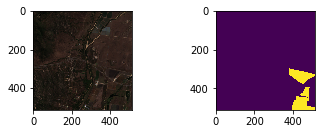

In [118]:
fname=x_train_filenames[0]
label_path = y_train_filenames[0]

plt.subplot(2,2,1)
plt.imshow(mpimg.imread(fname))
plt.subplot(2,2,2)
plt.imshow(mpimg.imread(label_path))
plt.show()

In [119]:
def _process_pathnames(fname, label_path):
  # We map this function onto each pathname pair  
  img_str = tf.read_file(fname)
  img = tf.image.decode_png(img_str, channels=3)

  label_img_str = tf.read_file(label_path)
  label_img = tf.image.decode_png(label_img_str)[0]
  # The label image should only have values of 1 or 0, indicating pixel wise
  # object (car) or not (background). We take the first channel only. 
  label_img = tf.expand_dims(label_img, axis=-1)
  return img, label_img

In [120]:
img_str = tf.read_file(fname)
img = tf.image.decode_png(img_str, channels=3)
#print(img.shape)

    
label_img_str=tf.read_file(label_path)
label_img=tf.image.decode_png(label_img_str)

with tf.Session() as sess:
    img = sess.run(label_img)
    print(img.shape, img[510][510])

(511, 511, 1) [0]


In [121]:
_process_pathnames(fname, label_path)

(<tf.Tensor 'DecodePng_61:0' shape=(?, ?, 3) dtype=uint8>,
 <tf.Tensor 'ExpandDims_1:0' shape=(?, ?, 1) dtype=uint8>)